# Exploratatory Analysis of the GECKO-A data set

Before we can apply any machine learning techniques, we must gather, prepare and explore the data available. Data is almost always presented in a way that makes building a model difficult if not impossible. This can be due to missing data, incorrect data types, variability in values between features that make modeling difficult, or any other number of reasons. We're going to start with loading the dataset. Then we will do some initial analysis of the data. How is it typed? What is the [Tukey 5-number Summary](https://machinelearningmastery.com/how-to-calculate-the-5-number-summary-for-your-data-in-python/#:~:text=The%20five%2Dnumber%20summary%2C%20or,for%20data%20with%20any%20distribution.)? How is the data distributed? Are the data in the features correlated? Then we move on to how we can scale and normalize the data to better help our algorithms solve for a model that can hopefully generalize well.

## Gathering the data

Data can be stored in a variety of ways with varying complexities and advantages. One very common way of storing data is as a csv file. CSV has the advantage of being human readable and easily accessible by a large variety of applications, but with the caveat that csv files do not necessarily distinguish between text and numeric data. Data is also not typed so you cannot assume your application will automatically be able to distinguish between int, float, bool, text, etc.

We will begin by loading a csv file into a pandas data frame. This will make it easier to explore the data as well as set the type for each column of data.

GECKO-A runs simulations of precursors under a variety of different conditions for 5 days at 5 minute increments. It would be overwhelming to start with a large dataset so we will start by only loading experiment 1000 for the toluene precursor.

**Note I want to ask about what DJ and John would like me to start with. Should I start with raw data or maybe just a single csv and doctor it up a little to run through changing data type and such in the tutorial?**
**Note that in the future I am going to want to implement a way to publicly retrieve this data. Also it may be stored in the parquet format rather than csv**

In [3]:
# We will need several popular data science tools for this notebook
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn
import sklearn.decomposition
import scipy
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline

In [303]:
file_path = "/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/ML2019_toluene_ML2019_Exp0.csv"

We can load the data using pandas built-in "read_csv" function and take a peek using the pd.head() function. 

In [304]:
dataFrame = pd.read_csv(file_path)
dataFrame.head()

,Time [s],Precursor [ug/m3],Temperature [K],OH [molec/cm3],O3 [molec/cm3],NOx [molec/cm3],SZA [degree],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,...,N/C Bin05: lg(C*) = -2.5,N/C Bin06: lg(C*) = -1.5,N/C Bin07: lg(C*) = -0.5,N/C Bin08: lg(C*) = 0.5,N/C Bin09: lg(C*) = 1.5,N/C Bin10: lg(C*) = 2.5,N/C Bin11: lg(C*) = 3.5,N/C Bin12: lg(C*) = 4.5,N/C Bin13: lg(C*) = 5.5,N/C Bin14: lg(C*) = 6.5
0,1.000000,0.037689,305.065338,4259464.0,2.131903e+12,4.663982e+10,156.839686,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,301.207794,0.037426,305.065338,4259464.0,2.131903e+12,3.089762e+11,156.845342,2.767639e-17,5.465436e-13,1.420820e-12,...,0.375269,0.150466,0.130869,0.217499,0.044273,0.143699,0.034506,0.116983,0.085254,0.001406
2,601.415588,0.037164,304.978027,4259464.0,2.131903e+12,3.365964e+11,156.787255,2.772026e-17,5.440976e-13,1.415403e-12,...,0.268998,0.065862,0.089287,0.223470,0.054207,0.144145,0.061240,0.104048,0.067545,0.002854
3,901.623352,0.036904,304.890747,4259464.0,2.131903e+12,3.391282e+11,156.665902,2.772170e-17,5.417454e-13,1.413397e-12,...,0.262669,0.028949,0.085632,0.228509,0.060956,0.144688,0.077644,0.096273,0.060124,0.004168
4,1201.831177,0.036646,304.803558,4259464.0,2.131903e+12,3.390159e+11,156.482265,2.803421e-17,5.397588e-13,1.422216e-12,...,0.262418,0.017990,0.097729,0.232256,0.068225,0.145245,0.087567,0.091117,0.056559,0.005371


Already we can see what columns are included in the data and get an idea of variablity in scale. Let's do some further formal investigation.

To see all the info available about a data frame you can use the built-in info function. We can see that all the data is fortuntately typed as float data. 

In [4]:
# Uncomment to see info about this dataframe
dataFrame.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 133 columns):
 #    Column                                                                                                                           Dtype  
---   ------                                                                                                                           -----  
 0     Time [s]                                                                                                                        float64
 1     Precursor [ug/m3]                                                                                                               float64
 2     Temperature [K]                                                                                                                 float64
 3     OH [molec/cm3]                                                                                                                  float64
 4     O3 [molec/cm3]             

A really simple way to get idea of scale of date is to compute the mean and variance of the columns with which you are working.

In [5]:
mean_list = [dataFrame[x].mean() for x in dataFrame]
variance_list = [dataFrame[x].var(ddof=1) for x in dataFrame]

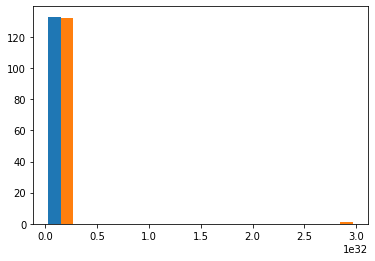

In [6]:
_ = plt.hist([mean_list,variance_list]);
plt.show()

We can so far see that there are 133 features in this matrix of data, there are 1440 time steps and the data is not well distributed at all.

There are a few ways we can distribute the data a little better. It's much easier to work with something that follows somewhat of a gaussian distribution. Like the following distribution with a mean of 0 and a variance of 1:

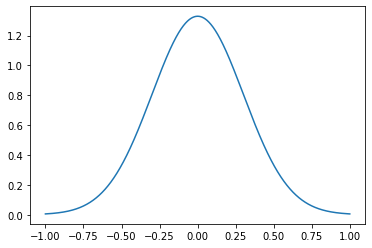

In [7]:
x_axis = np.arange(-1, 1, 0.001)
plt.plot(x_axis, stats.norm.pdf(x_axis,0,0.3))
plt.show()

## Data Preparation: Normalizing data

It's important to normalize and scale data because it makes it easier to solve for a local minima when evaluating the surface of the cost function for our model using gradient descent. Think of normalizing as smoothing the surface of the cost function. More information on scaling and normalizing [here.](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35#:~:text=Feature%20scaling%20is%20essential%20for,that%20calculate%20distances%20between%20data.&text=Since%20the%20range%20of%20values,not%20work%20correctly%20without%20normalization.)

### A visual of scaling effects

We're going to randomly draw 30 columns from our data frame and plot that data in a histogram.

In [8]:
np.random.seed(1234)
sample = np.random.choice(dataFrame.columns, size = 30)

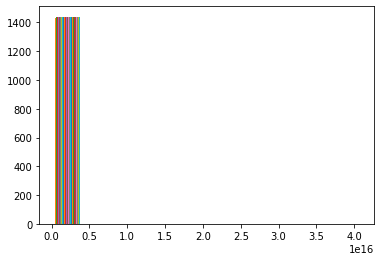

In [9]:
sampled_data = dataFrame.loc[:,sample]
_ = plt.hist(sampled_data)

You can see from the histogram that the data is not well distributed and the variance is very large. We can apply a scaling method that will compute the mean and variance of each individual column. Then we can transform our data by fitting that standardization to each column.

In [10]:
scaler = StandardScaler()

# Computed mean and standard deviation for each column
scaler  = scaler.fit(sampled_data)

# Applies a standarization to each column of data for the matrix shaped n_samples by n_features
sampled_data_scaled = scaler.transform(sampled_data)

Now if we plot the data we get a distribution that more closely resembles a standard normal distribution.

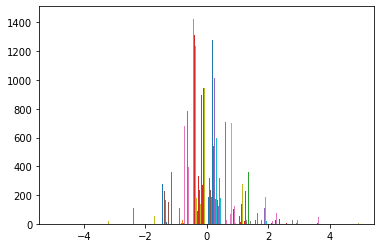

In [11]:
_ = plt.hist(sampled_data_scaled, bins = 20, range = [-5,5])

This is only one type of standardization method called Z-score standardization and is represented in the following way:

$x' = \frac{x - \bar{x}}{\sigma}$ , where ${x}$ is the original feature vector, ${\bar {x}}={\text{average}(x)}$ is the mean of that feature vector, and ${\displaystyle \sigma }$ is its standard deviation.

There are many other types of scaling and normalization techniques.

## TODO:

* add pre-existing aerosol data to toluene dataset

* remove all bins except gas and aerosol 

* add explanation of what the bins contain 

* create correlation matrix and explain matrix. Come up with possible explanations

* show distribution of features

* explain dataset a little. Maybe explain how some features were sampled using latin cube distribution

* use PCA to reduce dimension of matrix X
    - Explain drawback of using PCA
    - Include link to PCA 

* use other methods to reduce dimension of matrix X
 

## Correlation Matrix

Now that we know some scaling methods we can go ahead and expand our data frame to include other experiments and do some further exploration by building a correlation matrix. This will help us determine what features my be linear combinations of other features. There is a technique called Principal component analysis that we can use to reduce the dimension of our data by abstracting away linearly correlated data. First lets build our dataset...

### Building our dataset

There is data from thousands of experiments but we will start with 2000 experiments. Each experiment contains 1440 rows of data so our dataset will contain about 2.9 million rows of data and be size 2,880,000 by 133, this will equate to about 4 GB of data so plan on leaving between 25 and 30 minutes to load this.

**Note this will have to be a publically available source in the future. Can change filepath parameter**

In [12]:
def load_data(start_index=0, end_index=2000):
    dataFrame = pd.DataFrame()
    progress = 0
    for index in range(start_index, end_index):
        file_path = f"/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/ML2019_toluene_ML2019_Exp{str(index)}.csv"
        dataFrame = dataFrame.append(pd.read_csv(file_path))
        progress += 1
        if progress % 100 == 0:
            print(progress, "experiments loaded")
    return dataFrame

This is going to take awhile...

In [13]:
# Just run pd.read_parquet() line if you dont want to build the dataset from scratch
# dataFrame = load_data()
dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999.parquet")

We can save time by just saving our dataFrame as a parquet file for next time we want to load it. This takes seconds to read and write vs minutes to build the dataframe each time.

In [14]:
dataFrame.columns

Index(['Time [s]', 'Precursor [ug/m3]', 'Temperature [K]', 'OH [molec/cm3]',
       'O3 [molec/cm3]', 'NOx [molec/cm3]', 'SZA [degree]',
       'Gas [ug/m3] Bin01: lg(C*) = -6.5', 'Gas [ug/m3] Bin02: lg(C*) = -5.5',
       'Gas [ug/m3] Bin03: lg(C*) = -4.5',
       ...
       'N/C Bin05: lg(C*) = -2.5', 'N/C Bin06: lg(C*) = -1.5',
       'N/C Bin07: lg(C*) = -0.5', 'N/C Bin08: lg(C*) =  0.5',
       'N/C Bin09: lg(C*) =  1.5', 'N/C Bin10: lg(C*) =  2.5',
       'N/C Bin11: lg(C*) =  3.5', 'N/C Bin12: lg(C*) =  4.5',
       'N/C Bin13: lg(C*) =  5.5',
       'N/C Bin14: lg(C*) =  6.5                                                                                                      '],
      dtype='object', length=133)

Notice there is a space before every column name. Let's get rid of that.

In [15]:
# rename_columns = {}
# for column in dataFrame.columns:
#     rename_columns[column] = column[1:]
    
# dataFrame = dataFrame.rename(columns=rename_columns)

In [16]:
# Save dataFrame containing experiments 0 through 1999 to parquet file
# dataFrame.to_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999.parquet")

In [17]:
# To read just use pd.read_parquet()
# dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999.parquet")

Something that hasn't been discussed is what data is actually needed from the dataframe. The ultimate goal is going to be predicting amount of precursor at t+1 based on available input. It's time to start thinking about what is needed to do that. We will use the following features as input in our model:

* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx $(molec/cm^3)$: concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 $(molec/cm^3)$: concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH $(molec/cm^3)$: concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.
* Gas binned data $(ug/m^3)$: concentration of gas concentration binned by level of volatility 
* Aerosol binned data $(ug/m^3)$: concentration of aerosol conctration binned by level of volatility

We will have to add pre-existing aerosol data to our dataset and we can remove all the bins except those for gas and aerosol. We also will want to add exp # to our data.

In [18]:
df_summary_data = pd.read_csv("/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/TOLUENE_Exp_List_ML2019_toluene_v1_LatinHyperCube.csv", skiprows=3)

df_summary_data contains the parameters for the geck-a runs that generated our data. 

In [19]:
df_summary_data.columns

Index(['id', ' temperature (K)', ' solar zenith angle (degree)',
       ' pre-existing aerosols (ug/m3)', ' o3 (ppb)', ' nox (ppb)',
       ' oh (10^6 molec/cm3)'],
      dtype='object')

In [23]:
dataFrame = dataFrame.reset_index(drop=True);

In [24]:
dataFrame["id"] = "test"
dataFrame["pre-existing aerosols (ug/m3)"] = 0.0
for experiment in range(len(df_summary_data)):
    lower_index = experiment * 1440
    upper_index = lower_index + 1439

    dataFrame.loc[lower_index:upper_index, "id"] = df_summary_data.loc[experiment, "id"]
    dataFrame.loc[lower_index:upper_index, "pre-existing aerosols (ug/m3)"] = df_summary_data.loc[experiment, " pre-existing aerosols (ug/m3)"]

In [25]:
drop_list = ["Kh [M/atm] Bin01: lg(C*) = -6.5" , "Kh [M/atm] Bin02: lg(C*) = -5.5" , "Kh [M/atm] Bin03: lg(C*) = -4.5" , "Kh [M/atm] Bin04: lg(C*) = -3.5" , "Kh [M/atm] Bin05: lg(C*) = -2.5" , "Kh [M/atm] Bin06: lg(C*) = -1.5" , "Kh [M/atm] Bin07: lg(C*) = -0.5" , "Kh [M/atm] Bin08: lg(C*) =  0.5" , "Kh [M/atm] Bin09: lg(C*) =  1.5" , "Kh [M/atm] Bin10: lg(C*) =  2.5" , "Kh [M/atm] Bin11: lg(C*) =  3.5" , "Kh [M/atm] Bin12: lg(C*) =  4.5" , "Kh [M/atm] Bin13: lg(C*) =  5.5" , "Kh [M/atm] Bin14: lg(C*) =  6.5" , "MW [g/mol] Bin01: lg(C*) = -6.5" , "MW [g/mol] Bin02: lg(C*) = -5.5" , "MW [g/mol] Bin03: lg(C*) = -4.5" , "MW [g/mol] Bin04: lg(C*) = -3.5" , "MW [g/mol] Bin05: lg(C*) = -2.5" , "MW [g/mol] Bin06: lg(C*) = -1.5" , "MW [g/mol] Bin07: lg(C*) = -0.5" , "MW [g/mol] Bin08: lg(C*) =  0.5" , "MW [g/mol] Bin09: lg(C*) =  1.5" , "MW [g/mol] Bin10: lg(C*) =  2.5" , "MW [g/mol] Bin11: lg(C*) =  3.5" , "MW [g/mol] Bin12: lg(C*) =  4.5" , "MW [g/mol] Bin13: lg(C*) =  5.5" , "MW [g/mol] Bin14: lg(C*) =  6.5" , "dH [J/mol] Bin01: lg(C*) = -6.5" , "dH [J/mol] Bin02: lg(C*) = -5.5" , "dH [J/mol] Bin03: lg(C*) = -4.5" , "dH [J/mol] Bin04: lg(C*) = -3.5" , "dH [J/mol] Bin05: lg(C*) = -2.5" , "dH [J/mol] Bin06: lg(C*) = -1.5" , "dH [J/mol] Bin07: lg(C*) = -0.5" , "dH [J/mol] Bin08: lg(C*) =  0.5" , "dH [J/mol] Bin09: lg(C*) =  1.5" , "dH [J/mol] Bin10: lg(C*) =  2.5" , "dH [J/mol] Bin11: lg(C*) =  3.5" , "dH [J/mol] Bin12: lg(C*) =  4.5" , "dH [J/mol] Bin13: lg(C*) =  5.5" , "dH [J/mol] Bin14: lg(C*) =  6.5" , "kOH [cm3/molec/s] Bin01: lg(C*) = -6.5" , "kOH [cm3/molec/s] Bin02: lg(C*) = -5.5" , "kOH [cm3/molec/s] Bin03: lg(C*) = -4.5" , "kOH [cm3/molec/s] Bin04: lg(C*) = -3.5" , "kOH [cm3/molec/s] Bin05: lg(C*) = -2.5" , "kOH [cm3/molec/s] Bin06: lg(C*) = -1.5" , "kOH [cm3/molec/s] Bin07: lg(C*) = -0.5" , "kOH [cm3/molec/s] Bin08: lg(C*) =  0.5" , "kOH [cm3/molec/s] Bin09: lg(C*) =  1.5" , "kOH [cm3/molec/s] Bin10: lg(C*) =  2.5" , "kOH [cm3/molec/s] Bin11: lg(C*) =  3.5" , "kOH [cm3/molec/s] Bin12: lg(C*) =  4.5" , "kOH [cm3/molec/s] Bin13: lg(C*) =  5.5" , "kOH [cm3/molec/s] Bin14: lg(C*) =  6.5" , "O/C Bin01: lg(C*) = -6.5" , "O/C Bin02: lg(C*) = -5.5" , "O/C Bin03: lg(C*) = -4.5" , "O/C Bin04: lg(C*) = -3.5" , "O/C Bin05: lg(C*) = -2.5" , "O/C Bin06: lg(C*) = -1.5" , "O/C Bin07: lg(C*) = -0.5" , "O/C Bin08: lg(C*) =  0.5" , "O/C Bin09: lg(C*) =  1.5" , "O/C Bin10: lg(C*) =  2.5" , "O/C Bin11: lg(C*) =  3.5" , "O/C Bin12: lg(C*) =  4.5" , "O/C Bin13: lg(C*) =  5.5" , "O/C Bin14: lg(C*) =  6.5" , "H/C Bin01: lg(C*) = -6.5" , "H/C Bin02: lg(C*) = -5.5" , "H/C Bin03: lg(C*) = -4.5" , "H/C Bin04: lg(C*) = -3.5" , "H/C Bin05: lg(C*) = -2.5" , "H/C Bin06: lg(C*) = -1.5" , "H/C Bin07: lg(C*) = -0.5" , "H/C Bin08: lg(C*) =  0.5" , "H/C Bin09: lg(C*) =  1.5" , "H/C Bin10: lg(C*) =  2.5" , "H/C Bin11: lg(C*) =  3.5" , "H/C Bin12: lg(C*) =  4.5" , "H/C Bin13: lg(C*) =  5.5" , "H/C Bin14: lg(C*) =  6.5" , "N/C Bin01: lg(C*) = -6.5" , "N/C Bin02: lg(C*) = -5.5" , "N/C Bin03: lg(C*) = -4.5" , "N/C Bin04: lg(C*) = -3.5" , "N/C Bin05: lg(C*) = -2.5" , "N/C Bin06: lg(C*) = -1.5" , "N/C Bin07: lg(C*) = -0.5" , "N/C Bin08: lg(C*) =  0.5" , "N/C Bin09: lg(C*) =  1.5" , "N/C Bin10: lg(C*) =  2.5" , "N/C Bin11: lg(C*) =  3.5" , "N/C Bin12: lg(C*) =  4.5" , "N/C Bin13: lg(C*) =  5.5" , "N/C Bin14: lg(C*) =  6.5                                                                                                      "]

In [26]:
dataFrame = dataFrame.drop(columns = drop_list)

In [28]:
# dataFrame.to_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999_post_proc.parquet")

In [234]:
dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999_post_proc.parquet")

### Correlation

In [30]:
# We can remove the time domain before constructing a correlation matrix
dataFrame_corr = dataFrame.drop(columns = ["Time [s]", "id"])

<AxesSubplot:>

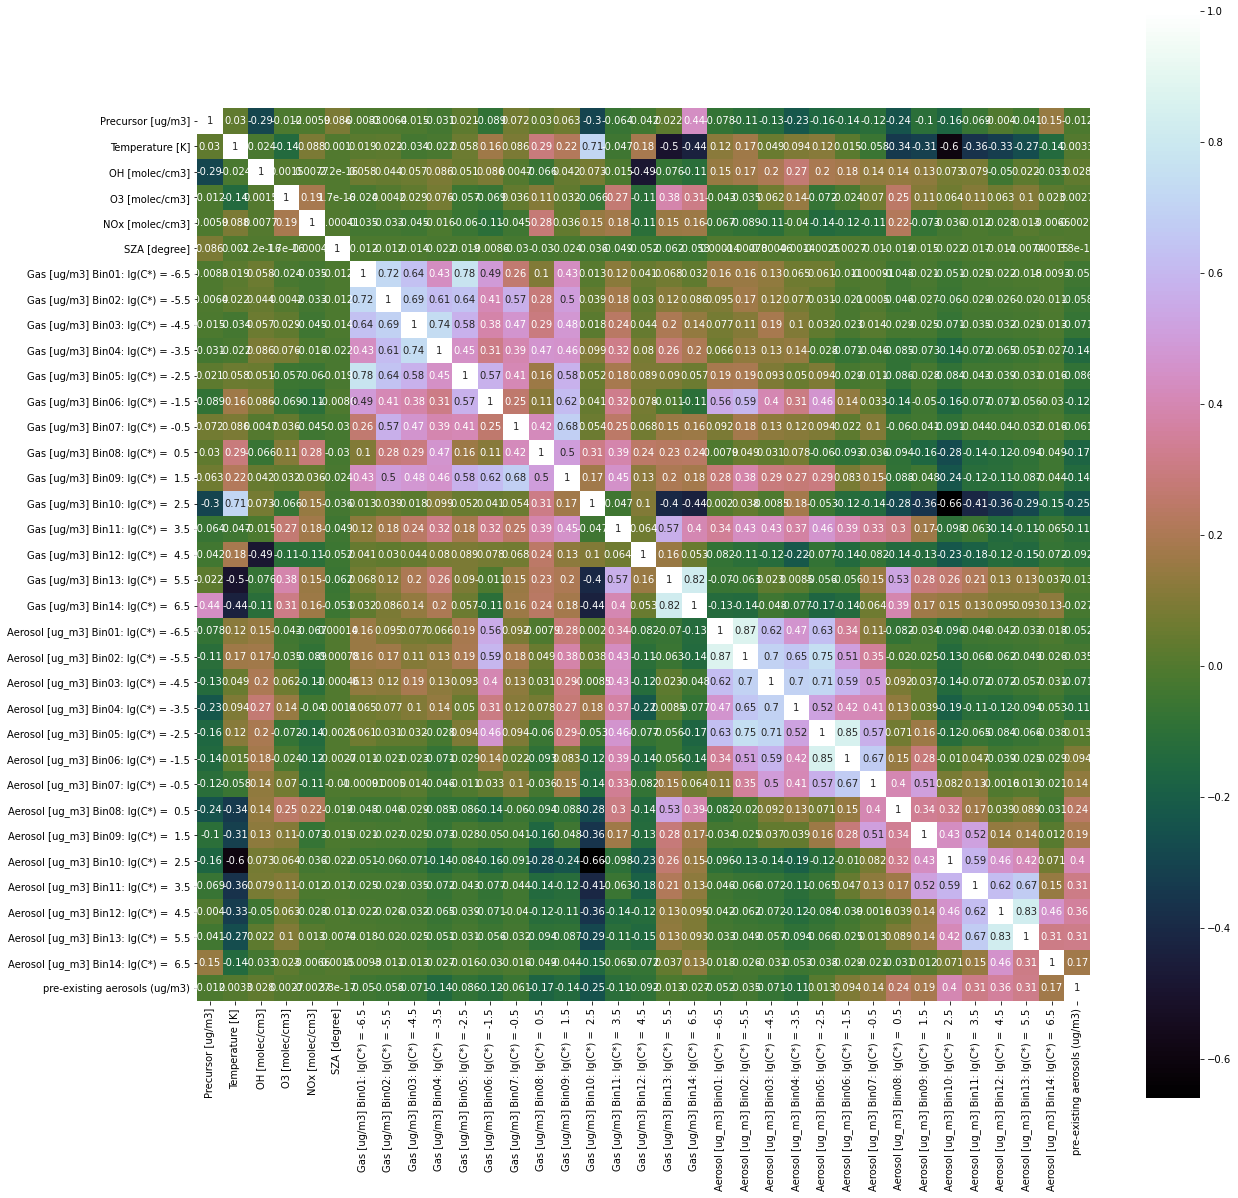

In [31]:
corr_mat = dataFrame_corr.corr(method='pearson')
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

**TODO: What can we say about the correlation matrix? What is there left to explore?**

### PCA Analysis of Binned Gas data and Aerosol Data

* normalize data first 

* explained variance ratio
    - How much does each component explain the variance
    - compare the original data and inverse tranform after PCA
    

* heat map

Because the correlation matrix suggests some values like the Gas binned data 1 through 9 is correlated there may be reason to try PCA analysis as a way to reduce the dimension of our feature matrix. PCA is a way of essentially smoothing out the surface represented by the matrix of input features in our model. Sklearn contains a library of functions that can assist in performing PCA. One of the first things we can do is fit PCA and then transform the data **TODO**

Let's just perform PCA on the binned gas data and then the binned aerosol data. 

In [4]:
dataFrame = pd.read_parquet("./ML2019_toluene_ML2019_Exp_0_1999_post_proc.parquet")

In [101]:
# count = 0
# for column in dataFrame.columns:
#     print(count, column)
#     count+=1

In [5]:
dataFrame_gas_binned = dataFrame[dataFrame.columns[7:21]]
dataFrame_aerosol_binned = dataFrame[dataFrame.columns[21:35]]

In [6]:
def plot_gas_aerosol_pca(pca_gas, pca_aero):
    plt.figure(figsize=(15,5))

    plt.plot(np.cumsum(pca_gas.explained_variance_ratio_), label = "Gas Binned")
    plt.plot(np.cumsum(pca_aero.explained_variance_ratio_), label = "Aerosol Binned")
    plt.legend(loc='best')

    plt.xlim(0,14,0.5)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.axhline(y = 0.85, color='r',linestyle='--' , linewidth=2)
    plt.show()
    plt.close()
    
def var_scale_data(dataFrame):
    scaler = StandardScaler()
    scaler = scaler.fit(dataFrame)
    scaled_data = scaler.transform(dataFrame)
    return scaled_data

def min_max_scale_data(dataFrame):
    scaler = MinMaxScaler()
    scaler = scaler.fit(dataFrame)
    scaled_data = scaler.transform(dataFrame)
    return scaled_data

You must normalize your data before applying PCA. If you do not normalize your data to have the same standard deviation for all features, some data will be wieghted disporportionately. After you fit PCA, you will generate a list of principal components specified when you fit the data. You can reduce the dimension of your data from the $(n \times m)$ matrix where n represents number of rows and m represents number of features to $(n \times k)$ where n represents the number of rows of data and k represents the number of components you want to reduce your data to. This allows you to visualize data by reducing the dimension. It also can help you solve machine learning algorithms like linear regression faster. When you reduce the dimension, you are also reducing the amount of information available to perform ML. This can be a problem if the cummulative explained variance drops below a certain threshold. Let's examine the effects of PCA with a really simple example before moving on to performing PCA on our dataset. 

### Example PCA (predicting housing prices)

Suppose you want to be able to predict housing prices based on number of features. Let's say we have available: (number of rooms, number of bathrooms, square ft, year built, and school quality). School quality will be ranked out of 1 through 10. We might have a feature matrix like the following.

In [23]:
example_data_frame = pd.DataFrame()
data = {'# bedrooms': [2,3,4,5,3], '# bathrooms' : [1,2,2,3,1],\
           'square ft': [900, 1200, 1300, 4000, 3500], 'year built': [1920,2008,2020,1965,2011],\
           'school quality': [4,8,3,7,1], 'price': [100000,175000,1000000,750000,400000]}
for column in data:
    example_data_frame[column] = data[column]

In [24]:
example_data_frame

,# bedrooms,# bathrooms,square ft,year built,school quality,price
0,2,1,900,1920,4,100000
1,3,2,1200,2008,8,175000
2,4,2,1300,2020,3,1000000
3,5,3,4000,1965,7,750000
4,3,1,3500,2011,1,400000


In [27]:
X = example_data_frame[example_data_frame.columns[0:5]]
y = example_data_frame[example_data_frame.columns[5]]

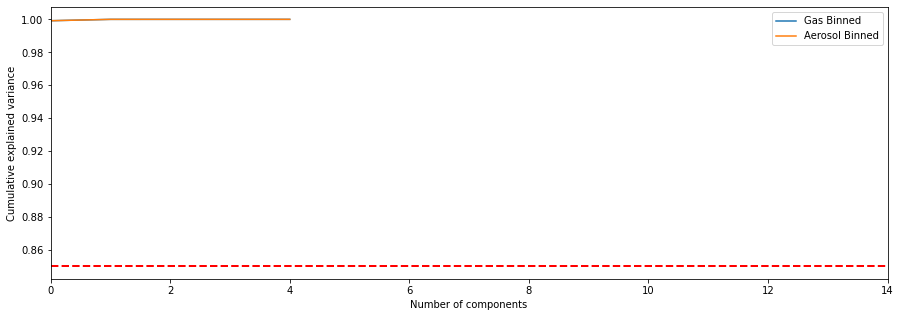

In [29]:
# Fit PCA to each set of binned data and plot the cummulative sum of the explained_variance_ratio
pca_X = PCA().fit(X)
plot_gas_aerosol_pca(pca_X, pca_X)

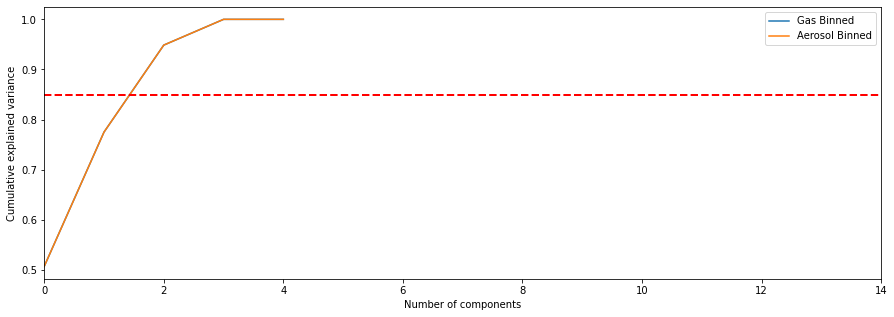

In [30]:
# Fit PCA to each set of binned data and plot the cummulative sum of the explained_variance_ratio
X = StandardScaler().fit_transform(X)
pca_X = PCA().fit(X)
plot_gas_aerosol_pca(pca_X, pca_X)

In [32]:
np.median(y)

400000.0

In [33]:
X_pca = PCA(n_components=2).fit_transform(X)

In [37]:
X_pca[:,0]

array([-2.19462812,  0.19744082,  0.20281342,  2.65269545, -0.85832157])

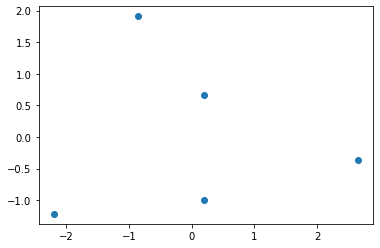

In [38]:
plt.scatter(X_pca[:,0], X_pca[:,1])

In [451]:
dataFrame_gas_binned_scaled = min_max_scale_data(dataFrame_gas_binned)
dataFrame_aerosol_binned_scaled = min_max_scale_data(dataFrame_aerosol_binned)

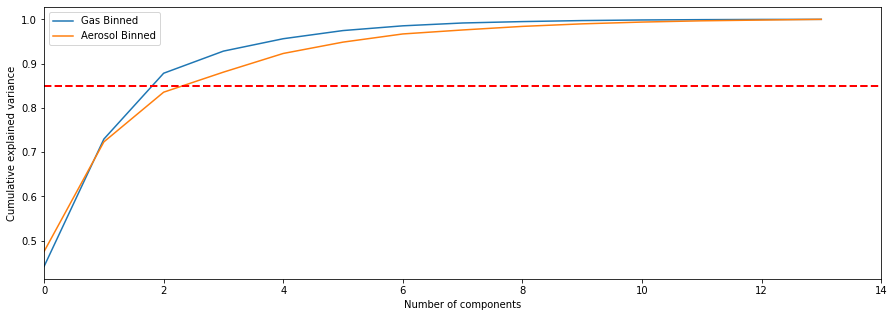

In [452]:
# Fit PCA to each set of binned data and plot the cummulative sum of the explained_variance_ratio
pca_gas_scaled = PCA().fit(dataFrame_gas_binned_scaled)
pca_aero_scaled = PCA().fit(dataFrame_aerosol_binned_scaled)
plot_gas_aerosol_pca(pca_gas_scaled, pca_aero_scaled)

In [486]:
pca = PCA().fit(dataFrame_gas_binned_scaled)


In [487]:
data = pca.transform(dataFrame_gas_binned_scaled)

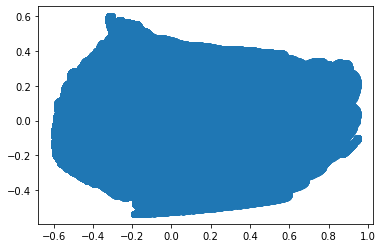

In [488]:
plt.scatter(data[:,0], data[:,1])

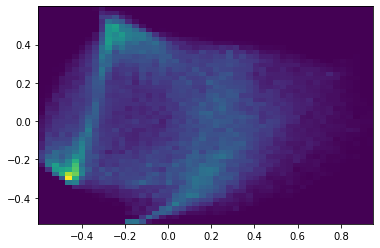

In [495]:
plt.hist2d(data[:,0], data[:,1], bins = 50);

In [473]:
gas_aerosol_scaled = StandardScaler().fit_transform(dataFrame[dataFrame.columns[7:35]])

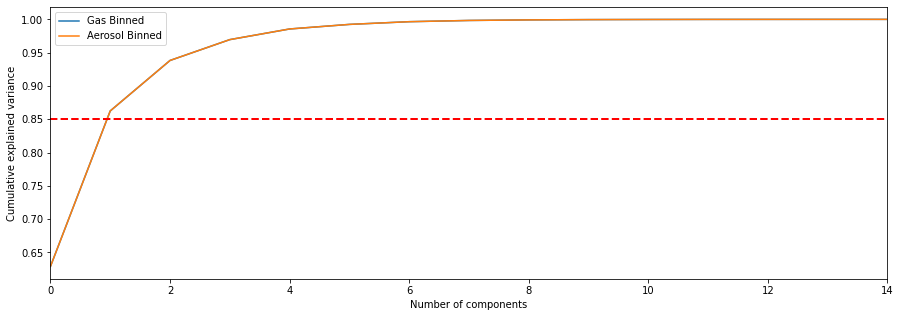

In [474]:
# Fit PCA to each set of binned data and plot the cummulative sum of the explained_variance_ratio
pca_gas_aerosol_scaled = PCA().fit(gas_aerosol_scaled)
plot_gas_aerosol_pca(pca_gas_aerosol_scaled, pca_gas_aerosol_scaled)

In [481]:
data = PCA().fit(gas_aerosol_scaled)
data = data.transform(gas_aerosol_scaled)

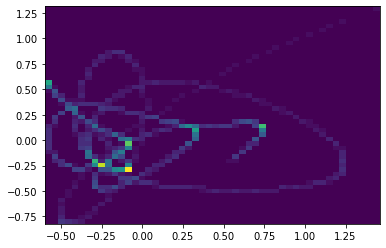

In [485]:
plt.hist2d(data[:,5], data[:,6], bins = 50);

In [401]:
# computer inverse transform of pca tranformed data
gas_inv_transform = pca.inverse_transform(pca.transform(dataFrame_gas_binned_scaled))

In [416]:
X = [x for x in range(len(dataFrame_gas_binned_scaled[:,0]))]
Y = dataFrame_gas_binned_scaled[:,0]

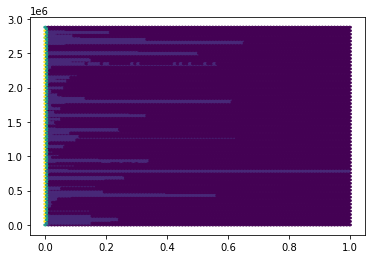

In [425]:
plt.hexbin(Y,X, bins=10)

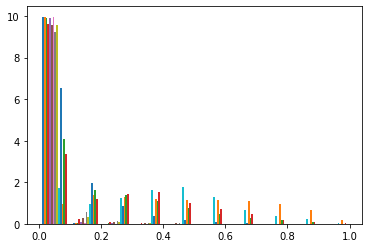

In [409]:
plt.hist(dataFrame_gas_binned_scaled, density=True);

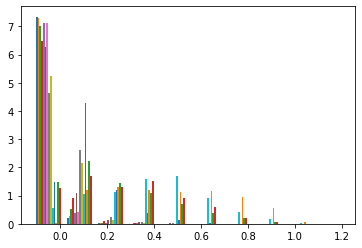

In [408]:
plt.hist(gas_inv_transform, density=True);

ValueError: operands could not be broadcast together with shapes (3,) (2880000,14) 

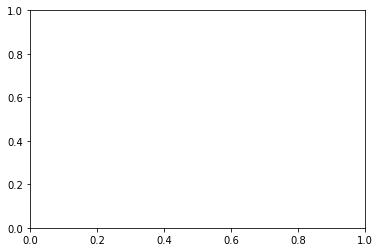

In [404]:
plt.hexbin([0,2,3],gas_inv_transform)

In [ ]:
plt.hist(dataFrame_gas_binned_scaled,bins = 20);

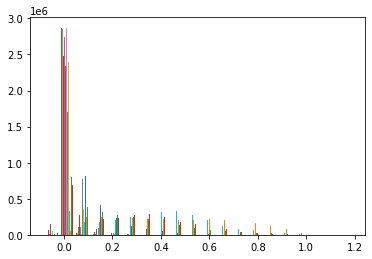

In [394]:
plt.hist(gas_inv_transform, bins = 20);

In [390]:
my_array = np.array([[1,2,3],[3,4,5],[6,7,8]])

## Constructing a basic linear model

So far we have peeked at the data and applied two scaling techniques. Let's construct a very basic model to predict precursor at t+n where t is the previous timestep and n represent the lead time. Lead time being t_delta between observation and prediction.


For our model we are give a matrix of predictors **X** and a vector of **y**. We are trying to solve for model *w* which minimizes the following:

$$\text{min}||Xw-y||^2 $$

There will me more on this later. Let's just abstract away model building for now so we can see the importance of feature scaling and normalization.

The general steps here will be.

*Step 1*: Build X and y

*Step 2*: Separate data into a training set, valuation set, and test set. (There is a bit of technique in this, but we will make this simple for now.)

*Step 3*: Use the training set to develop a model that will generalize to the valuation set. 

*Step 4*: Apply changes as necessary to avoid underfitting and overfitting. (More on this later.)

*Step 5*: Apply your model to the test set.

### Helper

In [155]:
def plot_GECKO_time_series(y, y_predictions, title):
    """
    notes
    -----
        Taken from seasonal_forecasting.ipynb notebook. Credit: Charlie Becker

    inputs
    ------
        y             pd.array  : time series of the true precursor amount
        predictions   np.array  : time series of the predicted values for y (same
                                  length and time as y)
        title                   : the title of the plot

    outputs
    -------
        None.  Displays the plot
    """
#     predictions = pd.Series(y_predictions, index=y.index)
#     predictions = predictions.sort_index()
#     y = y.sort_index()

    plt.plot(y, label='Ground Truth')
    plt.plot(y_predictions, '--', label='ML Predictions')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel('Precursor [ug/m3] ')
    plt.xlabel('Time-step')
    plt.show()
    plt.close()

### Step 1: Build X and y

In [ ]:
def assemble_predictors_predictands(start_index, end_index, lead_time, dataFrame):
    X = dataFrame.iloc[start_index:end_index,1:].values
    y = dataFrame.loc[start_index + lead_time: end_index + lead_time - 1,' Precursor [ug/m3]'].values
    #TODO
    # Add logic to make sure dataframe is not being overindexed when building vector of predictands
    
    """
    notes
    -----
        Taken from seasonal_forecasting.ipynb notebook. Credit: Charlie Becker
        We will ignore the time domain in our feature matrix.
        
    inputs
    ------

        start_index       int : the start index from which to extraxt features
        end_index         int : the end index
        lead_time         int : (n) the number of timesteps between each row of features
                              and the target amount of precursor

    outputs
    -------
        Returns a tuple of the predictors (np array of predictive features) 
        and the predictands (np array of precursor at t+n).
        """

    return X,y

In [185]:
X,y = assemble_predictors_predictands(start_index = 0, end_index = 1390, lead_time = 1, dataFrame = dataFrame)

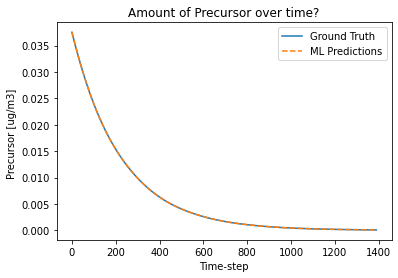

In [186]:
plot_GECKO_time_series(y,y,"Amount of Precursor over time?")

### Step 2: Separate data into a training set, valuation set, and test set. (There is a bit of technique in this, but we will make this simple for now.)

We are going to allocated about 55% of the lower half of data for training, 65-75% will be for valuation, and 85-95% for test set. This will be approximate separations going by index. There are other methods for creating sets but this will be covered in a later notebook.

In [173]:
for i in [1440 * 0.55, 1440 * 0.65, 1440 * 0.75, 1440 * 0.85, 1440 * 0.95]:
    print(int(i))

792
936
1080
1224
1368


In [183]:
X_train, y_train = assemble_predictors_predictands(start_index=0, end_index=1300, lead_time=1, dataFrame=dataFrame)
X_val, y_val = assemble_predictors_predictands(start_index=936, end_index=1080, lead_time=1, dataFrame=dataFrame)
X_test, y_test = assemble_predictors_predictands(start_index=1224, end_index=1368, lead_time=1, dataFrame=dataFrame)

### *Step 3*: Use the training set to develop a model that will generalize to the valuation set. 

RMSE: 0.00


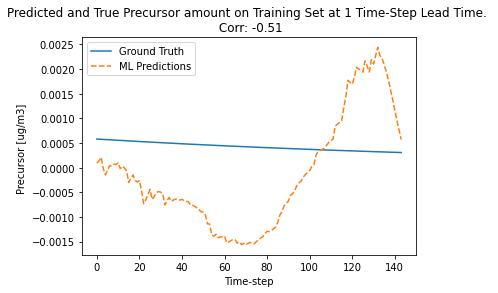

In [184]:
#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_GECKO_time_series(y_val, predictions, 
    'Predicted and True Precursor amount on Training Set at 1 Time-Step Lead Time. \n Corr: {:.2f}'.format(corr))

## Moving on to larger dataset

In [28]:
for x in range(0,1000,100):
    print(x, (x+99))

0 99
100 199
200 299
300 399
400 499
500 599
600 699
700 799
800 899
900 999
